In [55]:
import sys
if '/disks/cosmodm/vdvuurst' not in sys.path:
    sys.path.append('/disks/cosmodm/vdvuurst')

import numpy as np
import h5py
from matplotlib import pyplot as plt
import os
from importlib import reload
import json
import ONEHALO
from tqdm import tqdm
from functions import modified_logspace, Romberg
from onehalo_plotter import *
format_plot()

### Old version, lots of hardcoding

In [56]:
method = 'emcee'
rootpath = f'/disks/cosmodm/vdvuurst/data/OneHalo_param_fits/{method}'
rbins = modified_logspace(0, 5, 18)
rbin_centers = np.array([np.mean(rbins[i:i+2]) for i in range(17)])


def radial_param_scraper(rootpath, lower_mass = 2, upper_mass = 5.5, step = 0.5, rbins = rbins, save = False, single_gaussian = False):
    mass_range = np.arange(lower_mass, upper_mass + step, step).astype(np.float32)
    mass_bins = [f'M_1{mass_range[i]}-1{mass_range[i+1]}' for i in range(len(mass_range)-1)]

    rbin_keys = np.array([f'r_{rbins[i]:.2f}-{rbins[i+1]:.2f}' for i in range(len(rbins) - 1)])
    if single_gaussian:
        rbin_keys = rbin_keys + '_single_gaussian'
    #     params = ['sigma_1']
    # else:
    #     params = ['sigma_1', 'sigma_2', 'lambda']
    params = ['sigma_1', 'sigma_2', 'lambda']

    mass_dict = {mass_bin: {p:np.full(rbin_centers.shape, -1, dtype = np.float32) for p in params} for mass_bin in mass_bins}
    for mass_bin in mass_bins:
        for p in params:
            mass_dict[mass_bin][f'{p}_errors'] = np.full((*rbin_centers.shape,2), 0, dtype = np.float32)
        mass_dict[mass_bin]['likelihood'] = np.full(rbin_centers.shape,-np.inf, dtype = np.float32)
    
    for subdir, _, files in os.walk(rootpath):
        for file in files:
            if 'r_' in file and 'log' not in file: 
                if  ('single_gaussian' in file) == single_gaussian:
                    mass_bin_str = os.path.split(subdir)[1]
                    rbin_str = file.split('.json')[0]
                    filepath = os.path.join(subdir, file)
                    with open(filepath, 'r') as handle:
                        data = json.load(handle)
                    
                    # print(rbin_str, rbin_keys)
                    r_index = np.where(rbin_keys == rbin_str)[0][0]

                    for key,value in data.items():
                        try:
                            if key in ['nwalkers', 'nsteps']:
                                continue
                            elif key == 'errors':
                                sigma1err, sigma2err, lambdaerr = value
                                mass_dict[mass_bin_str]['sigma_1_errors'][r_index] = sigma1err
                                mass_dict[mass_bin_str]['sigma_2_errors'][r_index] = sigma2err
                                mass_dict[mass_bin_str]['lambda_errors'][r_index] = lambdaerr
                            else:
                                mass_dict[mass_bin_str][key][r_index] = value 
                        #TODO: with the try/except i do no errors for minimize now. but they should be just 0
                        except KeyError:
                            continue 

    #numpy to list
    for mbin in mass_bins:
        for p in params:
            data = mass_dict[mbin][p]
            mass_dict[mbin][p] = data.tolist()

    if save:
        with open(f'/disks/cosmodm/vdvuurst/data/OneHalo_param_fits/{method}/full_radial.json', 'w') as file:
            json.dump(mass_dict, file, indent = 1)
    
    return mass_dict

mass_dict = radial_param_scraper(rootpath)
mass_dict_single_gaussian = radial_param_scraper(rootpath, single_gaussian = True)
mass_dict_single_gaussian['M_12.0-12.5']

{'sigma_1': [121.01932525634766,
  116.58185577392578,
  112.06151580810547,
  110.56622314453125,
  111.52093505859375,
  116.82335662841797,
  122.33650207519531,
  130.5196990966797,
  140.7621612548828,
  158.70375061035156,
  177.75025939941406,
  198.12026977539062,
  248.1956024169922,
  -1.0,
  -1.0,
  -1.0,
  -1.0],
 'sigma_2': [537.28857421875,
  1325.7149658203125,
  579.8095703125,
  529.5988159179688,
  328.61322021484375,
  1212.999267578125,
  1175.288330078125,
  961.0885620117188,
  1071.5537109375,
  1042.904052734375,
  916.273681640625,
  1301.1280517578125,
  40.62293243408203,
  -1.0,
  -1.0,
  -1.0,
  -1.0],
 'lambda': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  -1.0,
  -1.0,
  -1.0,
  -1.0],
 'sigma_1_errors': array([[24.880291, 37.804745],
        [23.909248, 36.28176 ],
        [22.921808, 34.735806],
        [22.589228, 34.225853],
        [22.800642, 34.551018],
        [23.963703, 36.364365],
        [25.1678 

In [57]:
from scipy.optimize import curve_fit

def const_func(r,a):
    return np.full_like(r, a)

def linear_func(r, m, c):
    return m * r + c

def parabola_func(r, a, b, c):
    return a * r**2 + b * r + c

def exp_func(r, A, B, C):
    return A * np.exp(-B * r) + C

def exp_sq_func(r, A, B, C):
    return A * np.exp(-B * r**2) + C

def power_law_func(r, p, n, q):
    return p * np.power(r, n) + q

def power_linear_func(r, p, n, q, b):
    return p * np.power(r, n) + q * r + b

with open('/disks/cosmodm/vdvuurst/data/initial_params.json', 'r') as file:
    initial_params_full = json.load(file)
latex_formatter = {'sigma_1':r'$\sigma_1$', 'sigma_2': r'$\sigma_2$', 'lambda':r'$\lambda$'}

def fit_previous_best():

    for key, mass_bin_dict in mass_dict.items():
    # mass_bin_dict = mass_dict['M_12.5-13.0']

        # print(initial_params)
        if key in ['M_12.0-12.5','M_12.5-13.0','M_15.0-15.5']: # these are all 0 since Sowmya didn't do them before
            mkey = 'M_13.5-14.0'
        else:
            mkey = key
        initial_params = initial_params_full[mkey]

        sigma_1_init = np.array([initial_params[x] for x in ['p', 'n', 'q', 'b']])
        sigma_2_init = np.array([initial_params[x] for x in ['m', 'c']])
        lambda_init = np.array([initial_params[x] for x in ['A', 'B', 'C']])

        fig, axes = plt.subplots(nrows = 3, figsize = (10,10), sharex = False)
        for i,(param, values) in enumerate(mass_bin_dict.items()):
            # axes[i].set_title(latex_formatter[param])
            if 'errors' in param:
                continue
        
            match param:
                case 'sigma_1':
                    p0 = sigma_1_init
                    fit_func = power_linear_func
                    err = mass_bin_dict['sigma1_errors']

                case 'sigma_2':
                    p0 = sigma_2_init
                    fit_func = linear_func
                    err = mass_bin_dict['sigma2_errors']

                case 'lambda':
                    p0 = lambda_init
                    fit_func = exp_func
                    err = mass_bin_dict['lambda_errors']

            valid_idx = np.array(values) != -1
            try:
                popt, pcov = curve_fit(fit_func, xdata = rbin_centers[valid_idx], ydata = np.array(values)[valid_idx], p0 = p0, maxfev = 5000,
                                        sigma = np.mean(err[valid_idx], axis = 1))
                err_flag = False
            except RuntimeError:
                err_flag = True

            axes[i].errorbar(rbin_centers[valid_idx], np.array(values)[valid_idx], yerr = err[valid_idx].transpose(), fmt = '.', capsize = 2, color = 'black')

            if not err_flag:
                xvalues = np.linspace(np.min(rbin_centers[valid_idx]),np.max(rbin_centers[valid_idx]), 1000)
                match param:
                    case 'sigma_1':
                        yvalues = power_linear_func(xvalues, *popt)
                    case 'sigma_2':
                        yvalues = linear_func(xvalues, *popt)
                    case 'lambda':
                        yvalues = exp_func(xvalues, *popt)

                axes[i].plot(xvalues, yvalues, c = 'black')

            axes[i].set(ylabel = latex_formatter[param])
            axes[i].set(xlabel = 'r')
            axes[i].ticklabel_format(useOffset=False)

        plt.suptitle(key.replace('_',' = ')+' dex', fontsize = 20)
        plt.tight_layout()
        plt.show()
    
# fit_previous_best()

/var/tmp/vdvuurst/ipykernel_3836644/40641206.py:16: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-B * r**2) + C


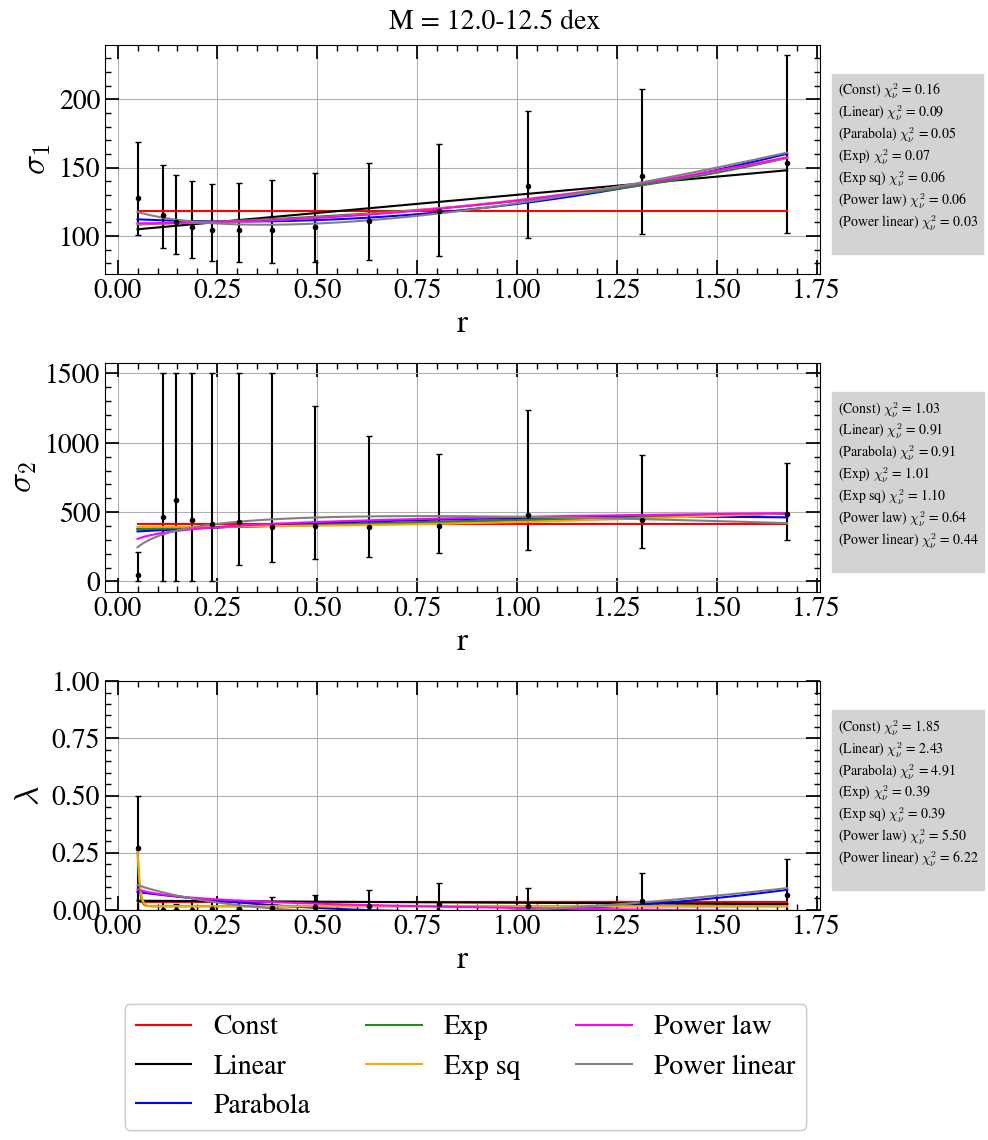

/var/tmp/vdvuurst/ipykernel_3836644/40641206.py:13: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-B * r) + C


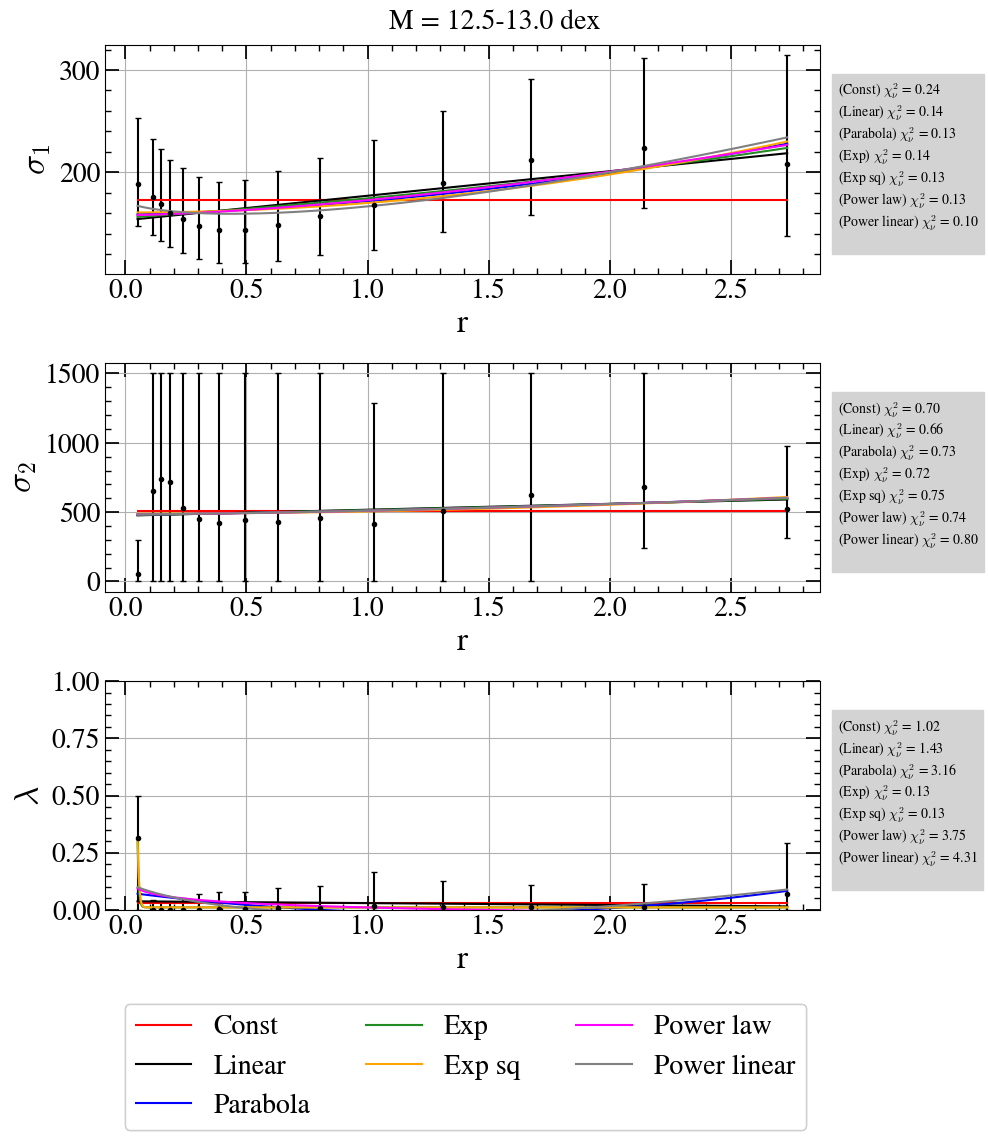

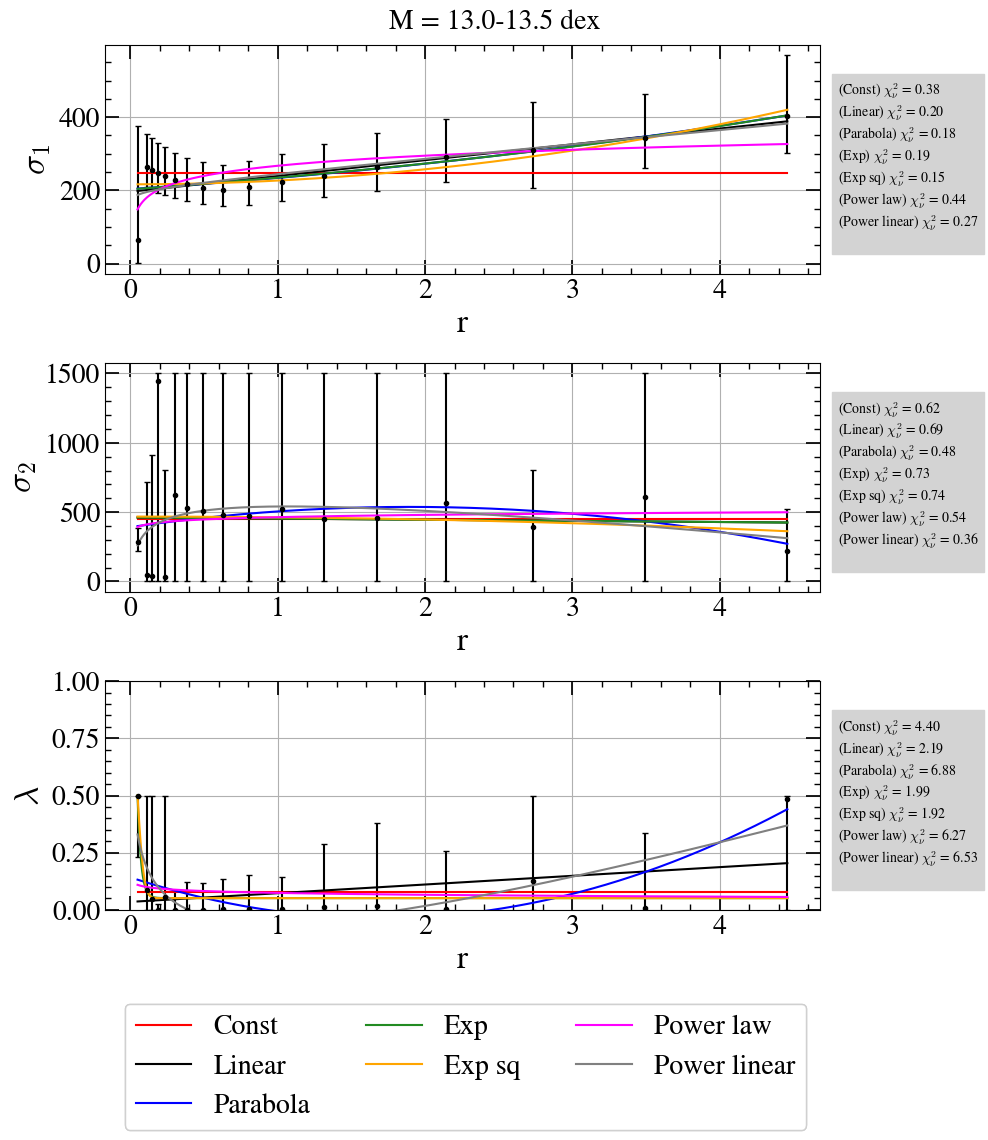

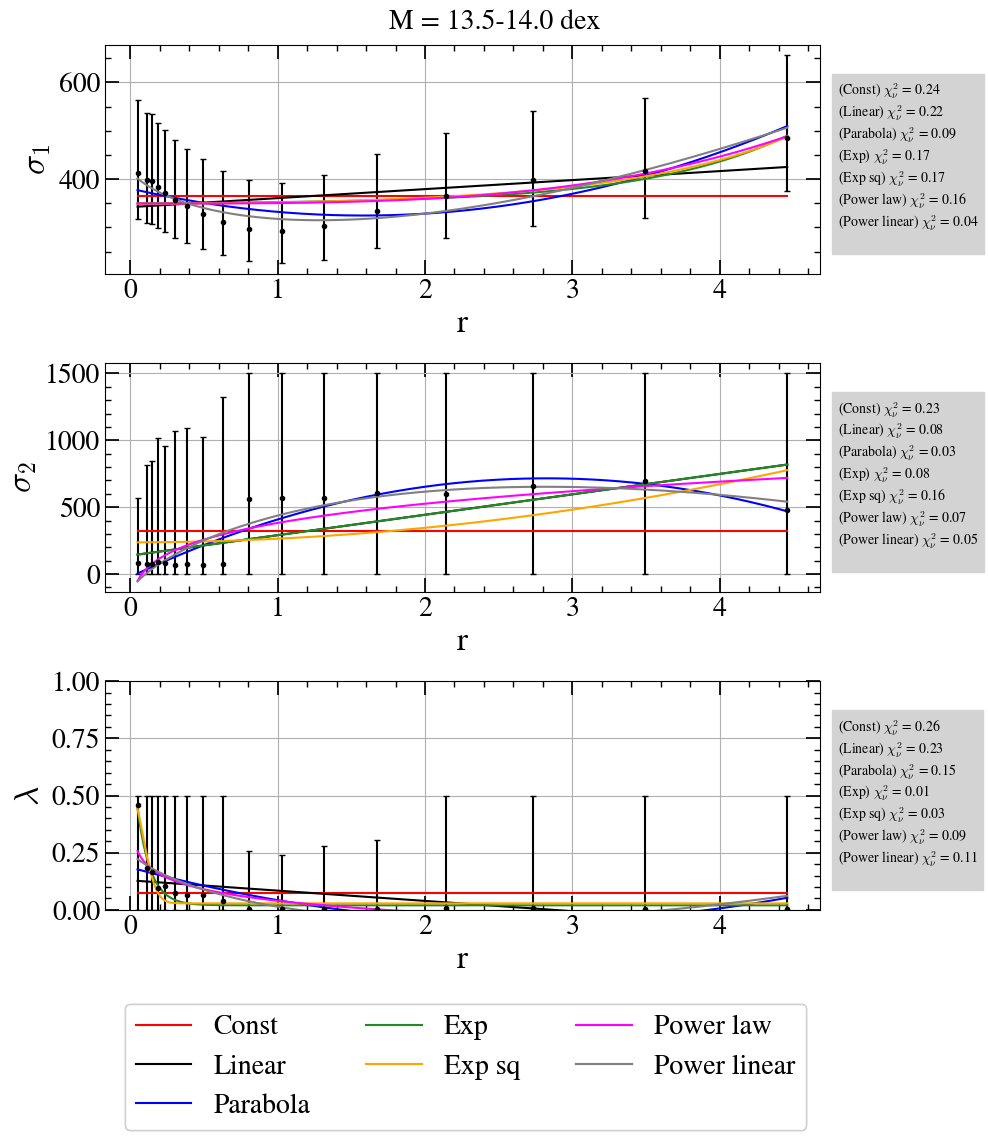

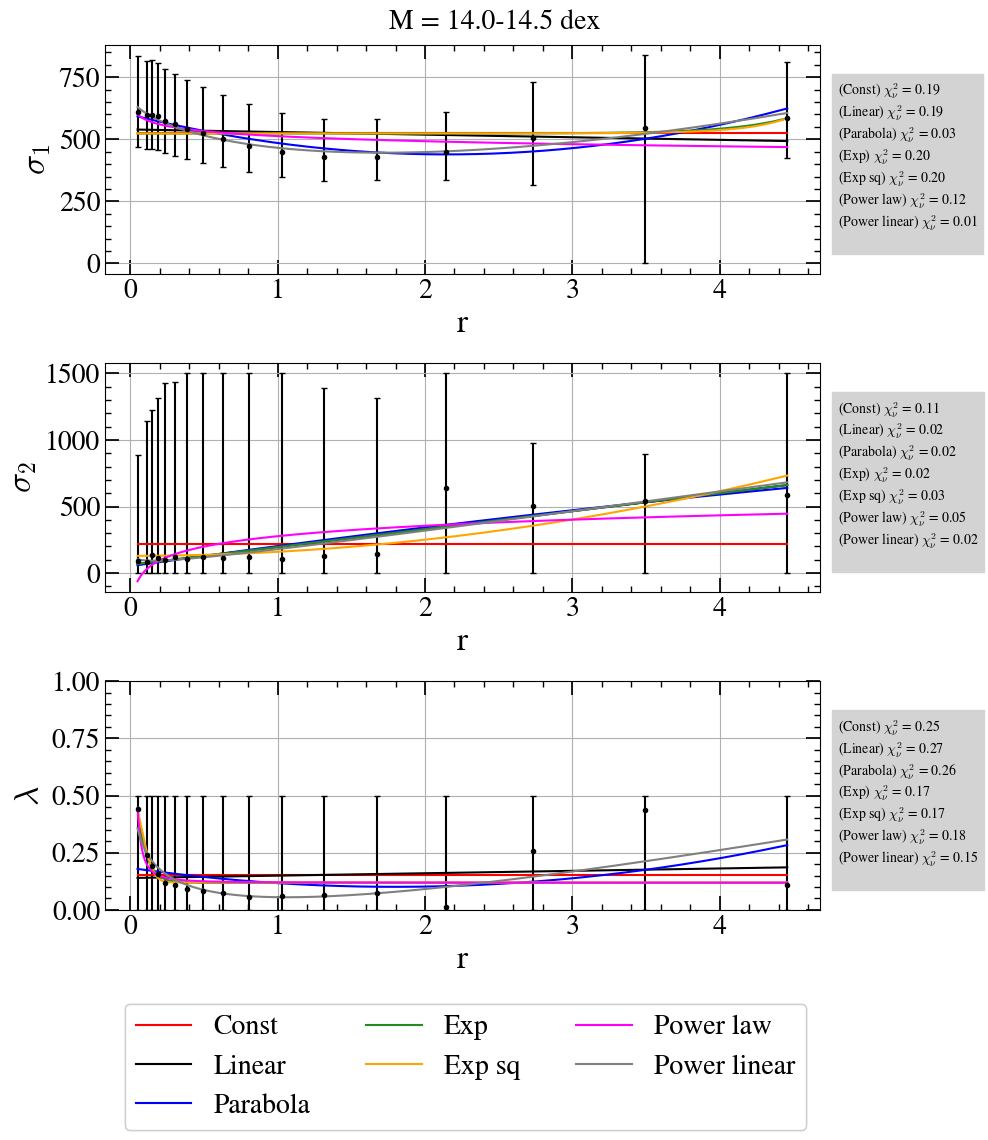

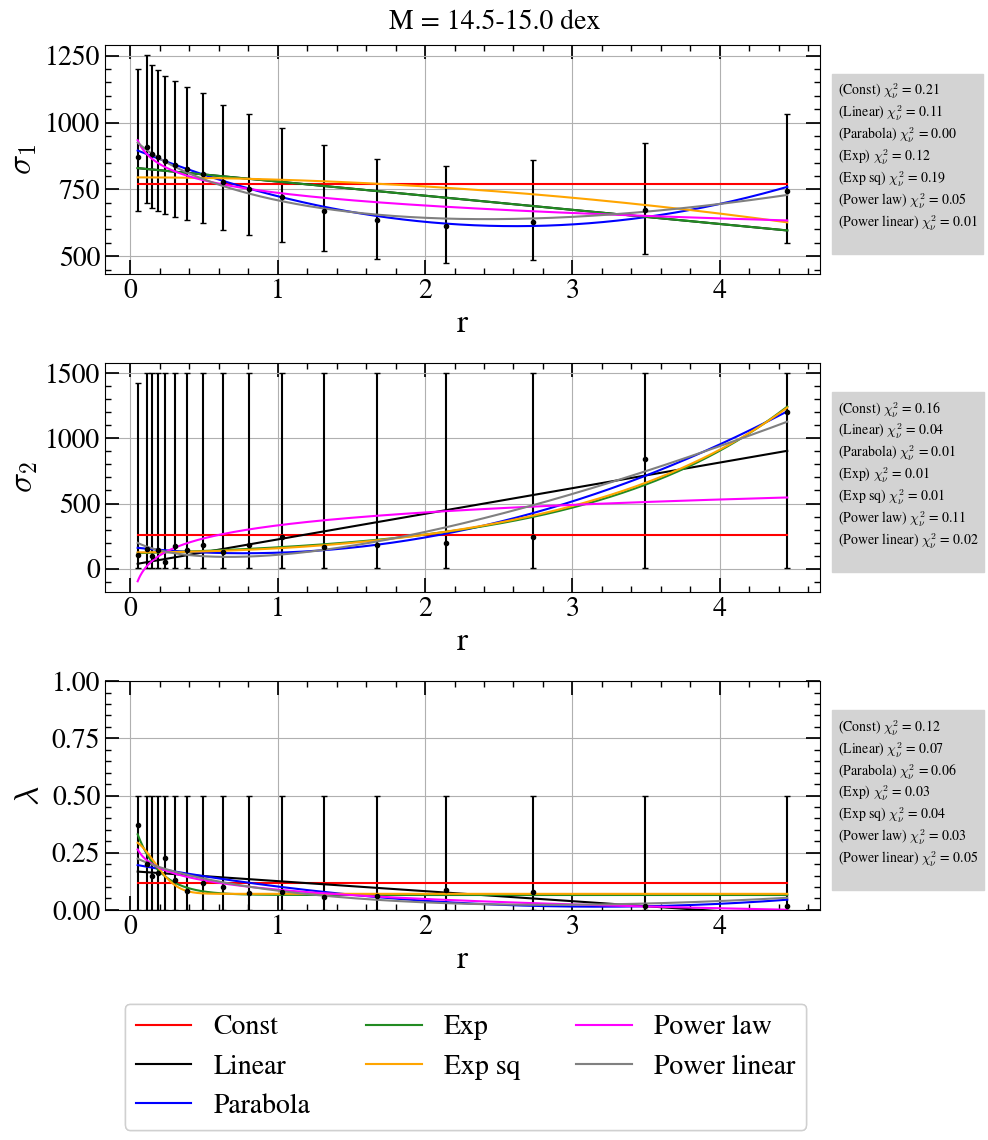

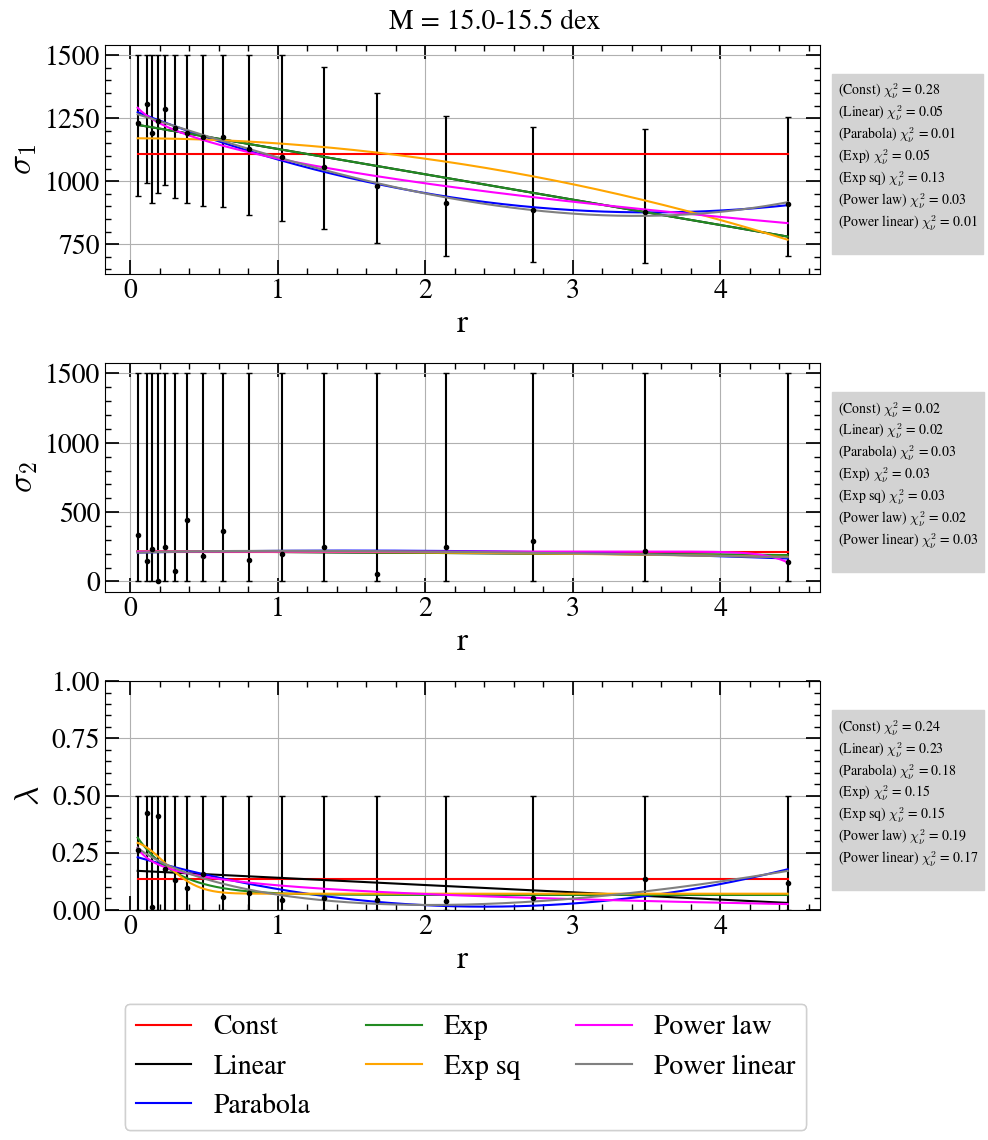

In [69]:
all_funcs = [const_func, linear_func, parabola_func, exp_func, exp_sq_func, power_law_func, power_linear_func]
func_names = [f.__name__.split('_func')[0] for f in all_funcs]
colors = ['red', 'black', 'blue', 'forestgreen', 'orange', 'magenta', 'gray']
color_dict = dict(zip(func_names,colors))
func_dict = dict(zip(func_names, all_funcs))


def reduced_chi2(O, E, sigma, dof):
    return np.sum(np.square(O - E) / sigma** 2) / dof


def fit_all_forms(mass_dict = mass_dict, range_str = None, skip_radbin = None):
    
    for key, mass_bin_dict in mass_dict.items():
        if range_str:
            mass_bin_dict = mass_dict[range_str]
            key = range_str

        # print(initial_params)
        if key in ['M_12.0-12.5','M_12.5-13.0','M_15.0-15.5']: # these are all 0 since Sowmya didn't do them before
            mkey = 'M_13.5-14.0'
        else:
            mkey = key
        initial_params = initial_params_full[mkey]

        if range_str:
            mkey = range_str

        # initial params based on sowmya's results and for the new function based on those
        # need only be in the ballpark
        power_linear_init = np.array([initial_params[x] for x in ['p', 'n', 'q', 'b']])
        linear_init = np.array([initial_params[x] for x in ['m', 'c']])
        exp_init = np.array([initial_params[x] for x in ['A', 'B', 'C']])
        exp_sq_init = exp_init.copy()
        power_law_init = power_linear_init.copy()[:-1]
        const_init = 400.
        parabola_init = np.hstack(([1], linear_init))

        init_list = [const_init, linear_init, parabola_init, exp_init, exp_sq_init, power_law_init, power_linear_init]

        fig, axes = plt.subplots(nrows = 3, figsize = (10,10), sharex = False)
        no_err = [True, True, True]
        for i,(param, values) in enumerate(mass_bin_dict.items()):
            if 'errors' in param:
                continue
            values = np.array(values)

            match param:
                case 'likelihood':
                    L = mass_bin_dict['likelihood']
                    continue
                case 'sigma_1':
                    err = mass_bin_dict['sigma_1_errors']
                    valid_idx = np.array(values) != -1
                case 'sigma_2':
                    err = mass_bin_dict['sigma_2_errors']
                    valid_idx = np.array(values) != -1
                case 'lambda':
                    err = mass_bin_dict['lambda_errors']
                    # values[0] = 1- values[0]
                    # err[0] = np.flip(err[0])
                    # values[-4:] = 1 - np.array(values[-4:])

                    valid_idx = np.array(values) != -1
                    # valid_idx[0] = False
            if skip_radbin is not None:
                print(valid_idx)
                valid_idx[skip_radbin] = False
                print(valid_idx)
            #plot the data
            # print(i)
            axes[i].errorbar(rbin_centers[valid_idx], np.array(values)[valid_idx],
                                yerr = err[valid_idx].transpose(), fmt = '.', capsize = 2, color = 'black')
            
            # loop over all functions for this parameter in this mass bin
            paramstr = ''
            for fit_func, func_name, init in zip(all_funcs,func_names,init_list):
                try:
                    xdata = rbin_centers[valid_idx]
                    ydata = np.array(values)[valid_idx]
                    errs = np.mean(err[valid_idx], axis = 1)
                    popt, pcov = curve_fit(fit_func, xdata = xdata, ydata = ydata,
                                            p0 = init, maxfev = 5000)
                                            # sigma = errs)
                    err_flag = False

                except RuntimeError:
                    print(f'ERROR OCCURED IN MASS BIN {key} FOR {param} on function {func_name}')
                    err_flag = True
                    no_err[i] = False

                if not err_flag:
                    pretty_func_label = f'{func_name[0].upper()}{func_name[1:].replace('_',' ')}'
                    # every function has a different number of parameters
                    num_args = len(popt)
                    dof = rbin_centers[valid_idx].size - num_args
                    chi2 = reduced_chi2(ydata, fit_func(xdata, *popt), errs, dof)
                    paramstr += f'({pretty_func_label}) ' + r'$\chi^2_{\nu}$ = ' + f'{chi2:.2f}\n'

                    xvalues = np.linspace(np.min(rbin_centers[valid_idx]),np.max(rbin_centers[valid_idx]), 1000)
                    yvalues = fit_func(xvalues, *popt)
                    axes[i].plot(xvalues, yvalues, label = pretty_func_label, c = color_dict[func_name])

            axes[i].text(1.025,0.125,paramstr,fontsize=10,backgroundcolor='lightgray',zorder=-1,transform=axes[i].transAxes)


            try:
                j = np.where(no_err)[0][0]
            except IndexError:
                j = -1

            handles, labels = axes[j].get_legend_handles_labels()
            fig.legend(handles, labels, bbox_to_anchor = [0.825, 0], ncols = 3)
            # make plot prettier
            axes[i].set(ylabel = latex_formatter[param])
            axes[i].set(xlabel = 'r')
            axes[i].ticklabel_format(useOffset=False)
            axes[i].grid()

        axes[-1].set_ylim(0,1)
        plt.suptitle(key.replace('_',' = ')+' dex', fontsize = 20)
        plt.tight_layout()
        plt.show()

        if range_str:
            break

# fit_all_forms('M_13.5-14.0', skip_radbin = -1)
fit_all_forms()

MASS BIN: M_12.0-12.5
rbin: 0.05: Single Gaussian has WORSE likelihood than Double Gaussian
rbin: 0.11384922491607298: Single Gaussian has WORSE likelihood than Double Gaussian
rbin: 0.14538369536373846: Single Gaussian has WORSE likelihood than Double Gaussian
rbin: 0.18565272528818344: Single Gaussian has WORSE likelihood than Double Gaussian
rbin: 0.23707565226414268: Single Gaussian has WORSE likelihood than Double Gaussian
rbin: 0.302741932870759: Single Gaussian has WORSE likelihood than Double Gaussian
rbin: 0.3865967552678352: Single Gaussian has WORSE likelihood than Double Gaussian
rbin: 0.49367806357840055: Single Gaussian has WORSE likelihood than Double Gaussian
rbin: 0.6304192343509734: Single Gaussian has WORSE likelihood than Double Gaussian
rbin: 0.8050355897098764: Single Gaussian has WORSE likelihood than Double Gaussian
rbin: 1.028017968656587: Single Gaussian has WORSE likelihood than Double Gaussian
rbin: 1.3127630099703773: Single Gaussian has WORSE likelihood th

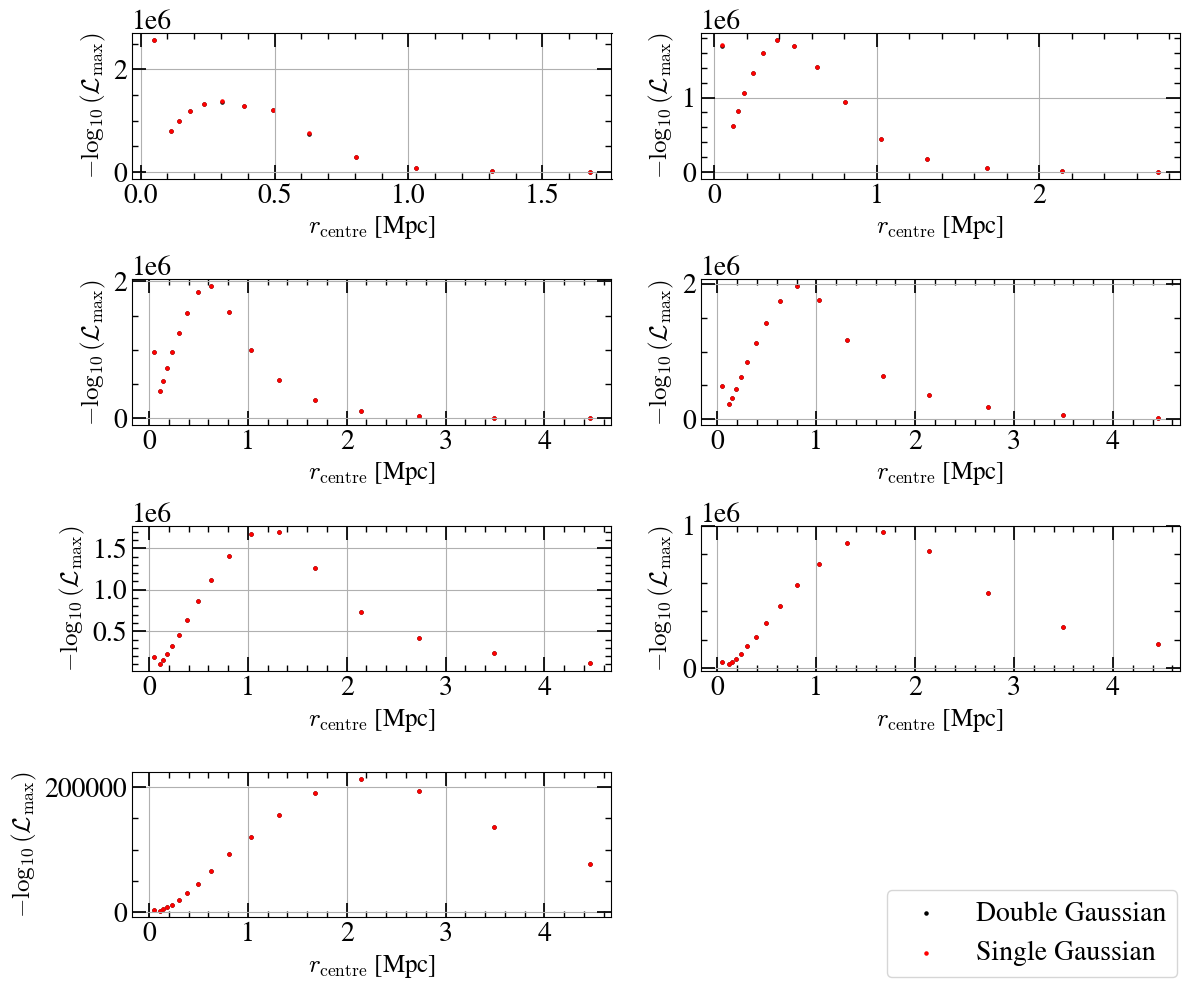

/var/tmp/vdvuurst/ipykernel_3836644/1789103976.py:57: RuntimeWarning: invalid value encountered in subtract
  L_diff = L_double - L_single


M_12.0-12.5 -1732.5 -486.1875 -1297.625 -3584.25 -6804.375 -12680.75 -14551.5 -17035.25 -11200.125 -4830.0312 -1338.0312 -254.01562 -57.171875 nan nan nan nan 
M_12.5-13.0 -1792.5 -27.6875 -72.125 -376.75 -445.75 -1174.875 -2262.375 -4403.625 -4642.625 -3811.8125 -1469.8438 -568.59375 -248.15234 -69.84082 -10.621948 nan nan 
M_13.0-13.5 -1983.0 -19.3125 -8.375 -21.5 -14.9375 -19.625 -71.25 -210.5 -618.0 -517.875 -522.6875 -164.5625 -41.1875 -15.6640625 -0.8378906 -0.37304688 -0.85131836 
M_13.5-14.0 -1282.7812 -54.71875 -63.1875 -29.75 -46.1875 -29.0625 -31.625 -40.625 -14.25 -28.625 -61.0 -46.125 -15.125 -8.1875 -6.46875 -2.0625 0.0 
M_14.0-14.5 -394.125 -37.453125 -42.28125 -38.453125 -28.4375 -36.96875 -31.625 -39.0625 -35.75 -31.875 -37.875 -46.75 -42.625 -7.1875 0.0 0.0 0.0 
M_14.5-15.0 -47.625 -7.0898438 -4.046875 -10.9609375 -17.601562 -16.875 -8.59375 -27.9375 -24.375 -18.625 -10.0625 -17.1875 -20.1875 -35.0625 -19.625 -0.375 -10.765625 
M_15.0-15.5 -1.8222656 -3.50708 -0.00634

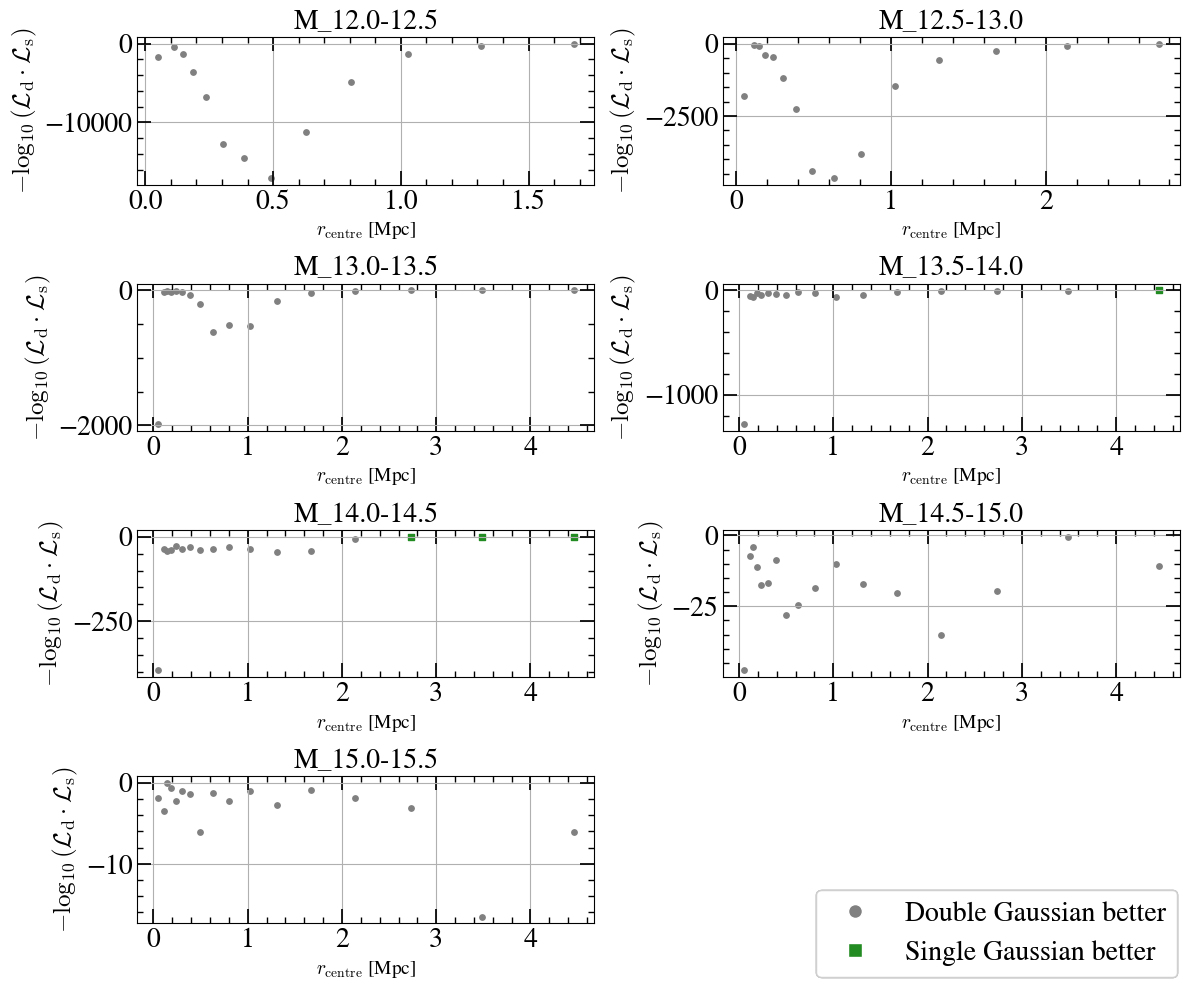

In [68]:
from matplotlib.lines import Line2D

def compare_models(range_str = None, mode = 'both'):
    # overlay
    if mode.lower() in ['both', 'overlay']:
        fig, axes = plt.subplots(figsize = (12,10), nrows = 4, ncols = 2)
        for i, (key, mass_bin_dict) in enumerate(mass_dict.items()):
            if range_str:
                mass_bin_dict = mass_dict[range_str]
                mass_bin_dict_single[range_str]
                key = range_str
            else:
                mass_bin_dict_single = mass_dict_single_gaussian[key]

            L_double = -1 * np.float64(mass_bin_dict['likelihood'])
            L_single = -1 * np.float64(mass_bin_dict_single['likelihood'])

            single_better_mask = L_single <= L_double
            print(f'MASS BIN: {key}')
            for j,r_centre in enumerate(rbin_centers):
                if L_double[j] == -np.inf or L_double[j] == 0.:
                    continue
                print(f'rbin: {r_centre}: Single Gaussian has {'BETTER' if single_better_mask[j] else 'WORSE'} likelihood than Double Gaussian')
            print()

            ax = axes[np.unravel_index(i, shape = (4,2))]
            ax.scatter(rbin_centers, L_double, color = 'black', label = '' if i != 6 else 'Double Gaussian', s = 5)
            ax.scatter(rbin_centers, L_single, color = 'red', label = '' if i != 6 else 'Single Gaussian', s = 5)
            ax.set_ylabel(r'$-\log_{10}(\mathcal{L}_{\mathrm{max}})$', fontsize =18)
            ax.set_xlabel(r'$r_{\mathrm{centre}}$ [Mpc]', fontsize =18)
            if i == 6:
                fig.legend(loc = 'lower right')
            ax.grid()
        
        axes[np.unravel_index(7, (4,2))].remove()
        fig.tight_layout()
        plt.show()

    if mode.lower() in ['both', 'diff', 'difference']:
        # Difference
        fig, axes = plt.subplots(figsize = (12,10), nrows = 4, ncols = 2)
        for i, (key, mass_bin_dict) in enumerate(mass_dict.items()):
            if range_str:
                mass_bin_dict = mass_dict[range_str]
                mass_bin_dict_single[range_str]
                key = range_str
            else:
                mass_bin_dict_single = mass_dict_single_gaussian[key]

            L_double = -1 * mass_bin_dict['likelihood']
            L_single = -1 * mass_bin_dict_single['likelihood']


            # Log(L) is a negative number which we want to MAXIMIZE (i.e. as close to 0 as possible because it wont be positive). Therefore we want -log(L) as 
            # SMALL as possible (again, as close to 0 as possible but now from a positive number).
            # So, if L_double / L_single is smaller than one that means L_single is larger which means it is a WORSE likelihood since they are neg_log_L now
            L_diff = L_double - L_single 
            # L_diff[L_diff == 0.] = np.nan


            ax = axes[np.unravel_index(i, shape = (4,2))]
            print(key , end=' ')
            # print(L_double[-1], L_single[-1], type(L_double[-1]))

            # single_better_border = 1. - (0.01 / 100)
            single_better_border = 0.
            for j, (r_c, L) in enumerate(zip(rbin_centers, L_diff)):
                print(L, end=' ')
                c = 'grey' if L < single_better_border else 'forestgreen'
                l = 'Double better' if L < single_better_border else 'Single better'
                m = 'o' if L < single_better_border else 's'
                ax.scatter(r_c, L, color = c, s = 15, label = l if (j == 16 and i == 6) else '', marker = m)
            print()
            ax.set_ylabel(r'$-\log_{10}(\mathcal{L}_{\mathrm{d}} \cdot \mathcal{L}_{\mathrm{s}})$', fontsize =18)
            # ax.set_ylabel(r'$\frac{-\log_{10}(\mathcal{L}_{\mathrm{d}})}{-\log_{10}(\mathcal{L}_{\mathrm{s}})}$', fontsize =18)
            ax.set_xlabel(r'$r_{\mathrm{centre}}$ [Mpc]', fontsize = 14)
            
            
            legend_elements = [Line2D([0], [0], marker='o', color='white', label='Double Gaussian better',markerfacecolor='grey', markersize=10),
                               Line2D([0], [0], marker='s', color='white', label='Single Gaussian better', markerfacecolor='forestgreen', markersize=10)]
            fig.legend(handles = legend_elements, loc = 'lower right')
            ax.grid()
            ax.set_title(key, fontsize = 20)
        
        axes[np.unravel_index(7, (4,2))].remove()
        fig.tight_layout()
        plt.show()


        
    

compare_models(mode = 'both')      
